In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('./data/HAM10000_Metadata')

(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [3]:
# Number of cases where we can use LSTM

(df['lesion_id'].value_counts() > 1).sum()

1956

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [5]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,3774,HAM_0003630,ISIC_0030538,nv,follow_up,65.0,female,upper extremity,vidir_molemax
1,4266,HAM_0007397,ISIC_0027393,nv,follow_up,50.0,female,trunk,vidir_molemax
2,5370,HAM_0004339,ISIC_0026332,nv,follow_up,75.0,male,lower extremity,vidir_molemax
3,3988,HAM_0005946,ISIC_0026368,nv,follow_up,55.0,male,genital,vidir_molemax
4,5914,HAM_0003196,ISIC_0025475,nv,follow_up,45.0,female,lower extremity,vidir_molemax


In [6]:
df['localization'].unique()

array(['upper extremity', 'trunk', 'lower extremity', 'genital', 'back',
       'chest', 'abdomen', 'unknown', 'face', 'foot', 'neck', 'scalp',
       'hand', 'ear', 'acral'], dtype=object)

In [7]:
temp = []

for i in range(0, 10015):
    loc = df.iloc[i]['localization']
    if loc == 'abdomen':
        temp.append(tf.one_hot(0, 15))
    elif loc == 'scalp':
        temp.append(tf.one_hot(1, 15))
    elif loc == 'lower extremity':
        temp.append(tf.one_hot(2, 15))
    elif loc == 'trunk':
        temp.append(tf.one_hot(3, 15))
    elif loc == 'upper extremity':
        temp.append(tf.one_hot(4, 15))
    elif loc == 'back':
        temp.append(tf.one_hot(5, 15))
    elif loc == 'neck':
        temp.append(tf.one_hot(6, 15))
    elif loc == 'face':
        temp.append(tf.one_hot(7, 15))
    elif loc == 'chest':
        temp.append(tf.one_hot(8, 15))
    elif loc == 'foot':
        temp.append(tf.one_hot(9, 15))
    elif loc == 'ear':
        temp.append(tf.one_hot(10, 15))
    elif loc == 'unknown':
        temp.append(tf.one_hot(11, 15))
    elif loc == 'hand':
        temp.append(tf.one_hot(12, 15))
    elif loc == 'acral':
        temp.append(tf.one_hot(13, 15))
    elif loc == 'genital':
        temp.append(tf.one_hot(14, 15))

In [8]:
one_hot_loc = np.array(temp)

one_hot_loc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# VGG-16
preprocessed = []

VGG_load = VGG16(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(VGG_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    preds = model.predict(img).reshape(25088)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['VGG16'] = preprocessed

  0%|                                                                                                                              | 0/10015 [00:00<?, ?it/s]2021-07-05 22:44:50.997909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-05 22:44:50.998055: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [11:05<00:00, 15.04it/s]


In [10]:
# Inception
preprocessed = []

IV3_load = InceptionV3(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(IV3_load)
model.add(layers.Flatten())

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preds = model.predict(img).reshape(131072)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['IV3'] = preprocessed

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [13:01<00:00, 12.82it/s]


In [11]:
# ResNet
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['resnet'] = preprocessed

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [14:42<00:00, 11.35it/s]


In [8]:
labels = []
for i in range(0, 10015):
    dx = df.iloc[i]['dx']
    if dx == 'akiec':
        labels.append(tf.one_hot(0, 7))
    elif dx == 'bcc':
        labels.append(tf.one_hot(1, 7))
    elif dx == 'bkl':
        labels.append(tf.one_hot(2, 7))
    elif dx == 'df':
        labels.append(tf.one_hot(3, 7))
    elif dx == 'mel':
        labels.append(tf.one_hot(4, 7))
    elif dx == 'nv':
        labels.append(tf.one_hot(5, 7))
    elif dx == 'vasc':
        labels.append(tf.one_hot(6, 7))
        
df['one_hot'] = labels

In [9]:
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,one_hot
0,3774,HAM_0003630,ISIC_0030538,nv,follow_up,65.0,female,upper extremity,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
1,4266,HAM_0007397,ISIC_0027393,nv,follow_up,50.0,female,trunk,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
2,5370,HAM_0004339,ISIC_0026332,nv,follow_up,75.0,male,lower extremity,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
3,3988,HAM_0005946,ISIC_0026368,nv,follow_up,55.0,male,genital,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
4,5914,HAM_0003196,ISIC_0025475,nv,follow_up,45.0,female,lower extremity,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."


(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [10]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,one_hot,risk
0,3774,HAM_0003630,ISIC_0030538,nv,follow_up,65.0,female,upper extremity,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",1.0
1,4266,HAM_0007397,ISIC_0027393,nv,follow_up,50.0,female,trunk,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",1.0
2,5370,HAM_0004339,ISIC_0026332,nv,follow_up,75.0,male,lower extremity,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",1.0
3,3988,HAM_0005946,ISIC_0026368,nv,follow_up,55.0,male,genital,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",1.0
4,5914,HAM_0003196,ISIC_0025475,nv,follow_up,45.0,female,lower extremity,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",1.0


In [11]:
VGG_X = np.array(df['VGG16'])
IV3_X = np.array(df['IV3'])
RES_X = np.array(df['resnet'])

KeyError: 'VGG16'

In [12]:
#y = np.array(df['one_hot'])

y = np.array(df['risk'])

In [18]:
vgg_model = models.Sequential()
vgg_model.add(layers.Dense(8192, activation='relu'))
vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(4))

In [19]:
new_VGG = []

for i in tqdm(range(0, 10015)):
    new_VGG.append(np.array(VGG_X[i]))

new_VGG = np.array(new_VGG)

new_VGG.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:00<00:00, 10213.63it/s]


(10015, 25103)

In [13]:
new_y = []
for ele in y:
    new_y.append(np.array(tf.one_hot(ele, 4)))
    
new_y = np.array(new_y)

new_y.shape

(10015, 4)

In [39]:
vgg_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model.fit(new_VGG, new_y, epochs=20, validation_split=0.1)

Epoch 1/20
282/282 [==============================] - 74s 256ms/step - loss: 0.1806 - accuracy: 0.9478 - val_loss: 1.0408 - val_accuracy: 0.7794
Epoch 2/20
282/282 [==============================] - 73s 259ms/step - loss: 0.1833 - accuracy: 0.9476 - val_loss: 1.0408 - val_accuracy: 0.7794
Epoch 3/20
282/282 [==============================] - 73s 260ms/step - loss: 0.1788 - accuracy: 0.9473 - val_loss: 1.0408 - val_accuracy: 0.7794
Epoch 4/20
282/282 [==============================] - 73s 257ms/step - loss: 0.1674 - accuracy: 0.9509 - val_loss: 1.0408 - val_accuracy: 0.7794
Epoch 5/20
282/282 [==============================] - 73s 259ms/step - loss: 0.1703 - accuracy: 0.9526 - val_loss: 1.0408 - val_accuracy: 0.7794
Epoch 6/20
282/282 [==============================] - 72s 255ms/step - loss: 0.1824 - accuracy: 0.9459 - val_loss: 1.0408 - val_accuracy: 0.7794
Epoch 7/20
 94/282 [=========>....................] - ETA: 45s - loss: 0.1763 - accuracy: 0.9465

KeyboardInterrupt: 

In [22]:
new_RES = []

for i in tqdm(range(0, 10015)):
    new_RES.append(np.array(RES_X[i]))

new_RES = np.array(new_RES)

new_RES.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:04<00:00, 2473.66it/s]


(10015, 100367)

In [23]:
res_model = models.Sequential()
#res_model.add(layers.Dense(8192, activation='relu'))
res_model.add(layers.Dense(4096, activation='relu'))
#res_model.add(layers.Dense(2048, activation='relu'))
res_model.add(layers.Dense(1024, activation='relu'))
#res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dense(128, activation='relu'))
res_model.add(layers.Dense(4))

In [24]:
res_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
res_model.fit(new_RES, new_y, epochs=5, validation_split=0.1)

Epoch 1/5
282/282 [==============================] - 258s 882ms/step - loss: 10.2251 - accuracy: 0.6478 - val_loss: 0.6165 - val_accuracy: 0.7745
Epoch 2/5
282/282 [==============================] - 253s 894ms/step - loss: 0.4208 - accuracy: 0.8463 - val_loss: 0.6042 - val_accuracy: 0.8014
Epoch 3/5
282/282 [==============================] - 251s 889ms/step - loss: 0.2038 - accuracy: 0.9263 - val_loss: 0.7178 - val_accuracy: 0.7914
Epoch 4/5
282/282 [==============================] - 250s 886ms/step - loss: 0.0924 - accuracy: 0.9679 - val_loss: 0.8680 - val_accuracy: 0.7385
Epoch 5/5
282/282 [==============================] - 255s 902ms/step - loss: 0.0952 - accuracy: 0.9674 - val_loss: 0.9337 - val_accuracy: 0.7964


In [25]:
new_IV3 = []

for i in tqdm(range(0, 10015)):
    new_IV3.append(np.array(IV3_X[i]))

new_IV3 = np.array(new_IV3)

new_IV3.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:10<00:00, 998.08it/s]


(10015, 131087)

In [26]:
iv3_model = models.Sequential()
#iv3_model.add(layers.Dense(8192, activation='relu'))
iv3_model.add(layers.Dense(1024, activation='relu'))
#iv3_model.add(layers.Dense(2048, activation='relu'))
iv3_model.add(layers.Dense(256, activation='relu'))
#iv3_model.add(layers.Dense(512, activation='relu'))
#iv3_model.add(layers.Dense(128, activation='relu'))
iv3_model.add(layers.Dense(4))

In [27]:
iv3_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
iv3_model.fit(new_IV3, new_y, epochs=5, validation_split=0.1)

Epoch 1/5
282/282 [==============================] - 80s 277ms/step - loss: 15.1425 - accuracy: 0.6255 - val_loss: 1.0636 - val_accuracy: 0.7006
Epoch 2/5
282/282 [==============================] - 74s 263ms/step - loss: 0.5949 - accuracy: 0.8075 - val_loss: 0.7435 - val_accuracy: 0.7485
Epoch 3/5
282/282 [==============================] - 74s 263ms/step - loss: 0.3083 - accuracy: 0.8863 - val_loss: 0.8353 - val_accuracy: 0.7485
Epoch 4/5
282/282 [==============================] - 75s 265ms/step - loss: 0.2014 - accuracy: 0.9214 - val_loss: 0.9739 - val_accuracy: 0.6936
Epoch 5/5
282/282 [==============================] - 75s 265ms/step - loss: 0.2040 - accuracy: 0.9233 - val_loss: 1.1670 - val_accuracy: 0.7645


In [46]:
predict_y_iv3 = []
temp_iv3 = iv3_model.predict(new_IV3)

for i in tqdm(range(0, 10015)):
    pred = np.argmax(temp_iv3[i])
    predict_y_iv3.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:00<00:00, 501497.77it/s]


In [47]:
predict_y_vgg = []
temp_vgg = vgg_model.predict(new_VGG)

for i in tqdm(range(0, 10015)):
    pred = np.argmax(temp_vgg[i])
    predict_y_vgg.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:00<00:00, 480106.46it/s]


In [48]:
predict_y_res = []
temp_res = res_model.predict(new_RES)

for i in tqdm(range(0, 10015)):
    pred = np.argmax(temp_res[i])
    predict_y_res.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:00<00:00, 491826.93it/s]


In [31]:
cm_iv3 = tf.math.confusion_matrix(np.array(df['risk']), np.array(predict_y_iv3))

In [32]:
cm_vgg = tf.math.confusion_matrix(np.array(df['risk']), np.array(predict_y_vgg))

In [33]:
cm_res = tf.math.confusion_matrix(np.array(df['risk']), np.array(predict_y_res))

In [34]:
cm_iv3 = np.array(cm_iv3).astype('float32')
cm_vgg = np.array(cm_vgg).astype('float32')

cm_res = np.array(cm_res).astype('float32')



In [35]:
cm_iv3[0] = cm_iv3[0] / 1356
cm_iv3[1] = cm_iv3[1] / 6705
cm_iv3[2] = cm_iv3[2] / 326
cm_iv3[3] = cm_iv3[3] / 1627

cm_vgg[0] = cm_vgg[0] / 1356
cm_vgg[1] = cm_vgg[1] / 6705
cm_vgg[2] = cm_vgg[2] / 326
cm_vgg[3] = cm_vgg[3] / 1627

cm_res[0] = cm_res[0] / 1356
cm_res[1] = cm_res[1] / 6705
cm_res[2] = cm_res[2] / 326
cm_res[3] = cm_res[3] / 1627

<AxesSubplot:>

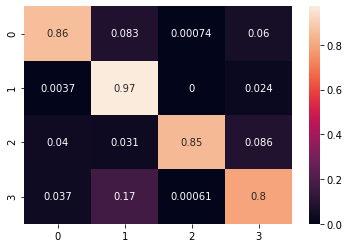

In [36]:
import seaborn as sns

sns.heatmap(cm_iv3, annot=True)

<AxesSubplot:>

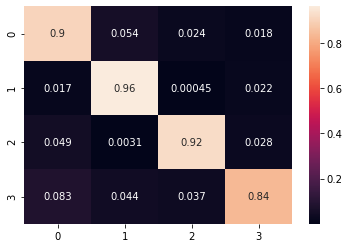

In [37]:
sns.heatmap(cm_vgg, annot=True)

<AxesSubplot:>

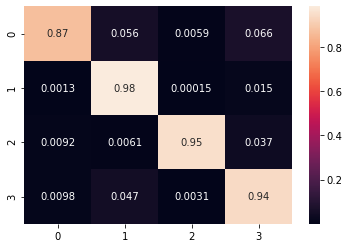

In [38]:
sns.heatmap(cm_res, annot=True)

In [14]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 2 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([])#np.array([age])#, sex])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:01<00:00, 5669.24it/s]


In [15]:
feat_X = np.array(feature_vector)

In [16]:
feat_X[0].astype('float32')

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [17]:
class_weights = {3:4,  1:1, 2:20, 0:4}

In [18]:
sample_weights = []

for i in range(0, 10015):
    sample_weights.append(class_weights[df.iloc[i]['risk']])
    
df['weight'] = sample_weights

In [19]:
sample_weights = np.array(sample_weights)

In [20]:
of_model = models.Sequential()

of_model.add(layers.Dense(4))

In [ ]:
of_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
history = of_model.fit(feat_X, new_y, epochs=10, validation_split=0.1, sample_weight=sample_weights)

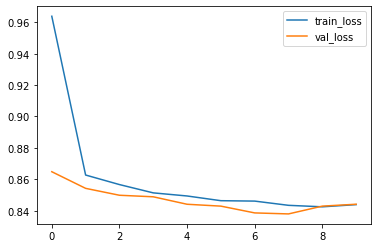

In [156]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")

plt.legend()

In [129]:
new_X = []

for i in tqdm(range(0, 10015)):
    feat = np.concatenate((temp_iv3[i] - 9, temp_vgg[i] + 1, temp_res[i] + 6, feature_vector[i]))
    new_X.append(feat)
    
new_X = np.array(new_X)
new_X.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:00<00:00, 166207.50it/s]


(10015, 15)

In [130]:
new_X[4]

array([ 1.98716259,  9.03957748, -7.54617786,  0.83979797, -2.90297103,
        6.15016937, -9.95054722,  1.58877742,  0.42285728,  6.60224485,
       -5.88574696,  4.4694972 ,  2.        ,  9.        ,  4.        ])

In [131]:
new_y.shape

(10015, 4)

In [24]:
final_model = models.Sequential()

final_model.add(layers.Dense(64, activation='relu'))
final_model.add(layers.Dense(32, activation='relu'))
final_model.add(layers.Dense(16, activation='relu'))
final_model.add(layers.Dense(8, activation='relu'))
final_model.add(layers.Dense(4))

In [25]:
final_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
final_model.fit(new_X, new_y, epochs=10, validation_split=0.1, shuffle=True)

NameError: name 'new_X' is not defined

In [134]:
predict_y_final = []
temp_final = final_model.predict(new_X)

for i in tqdm(range(0, 10015)):
    pred = np.argmax(temp_final[i])
    predict_y_final.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:00<00:00, 512855.65it/s]


In [135]:
cm_final = tf.math.confusion_matrix(np.array(df['risk']), np.array(predict_y_final))

cm_final = np.array(cm_final).astype('float32')

cm_final[0] = cm_final[0] / 1356
cm_final[1] = cm_final[1] / 6705
cm_final[2] = cm_final[2] / 326
cm_final[3] = cm_final[3] / 1627

<AxesSubplot:>

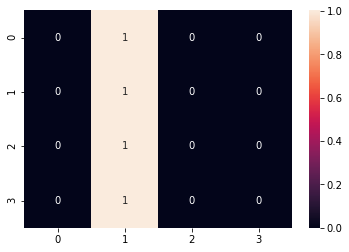

In [136]:
sns.heatmap(cm_final, annot=True)

# New Original Model

In [38]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [39]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,8821,HAM_0006366,ISIC_0030732,nv,histo,65.0,female,upper extremity,rosendahl
1,7580,HAM_0001026,ISIC_0033743,nv,histo,20.0,female,foot,vidir_modern
2,6473,HAM_0002059,ISIC_0028061,nv,follow_up,40.0,female,trunk,vidir_molemax
3,1553,HAM_0000611,ISIC_0033804,mel,histo,30.0,female,back,vidir_modern
4,8823,HAM_0002025,ISIC_0025169,nv,histo,5.0,male,scalp,rosendahl


In [40]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,8821,HAM_0006366,ISIC_0030732,nv,histo,65.0,female,upper extremity,rosendahl,1.0
1,7580,HAM_0001026,ISIC_0033743,nv,histo,20.0,female,foot,vidir_modern,1.0
2,6473,HAM_0002059,ISIC_0028061,nv,follow_up,40.0,female,trunk,vidir_molemax,1.0
3,1553,HAM_0000611,ISIC_0033804,mel,histo,30.0,female,back,vidir_modern,3.0
4,8823,HAM_0002025,ISIC_0025169,nv,histo,5.0,male,scalp,rosendahl,1.0


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'risk 3')

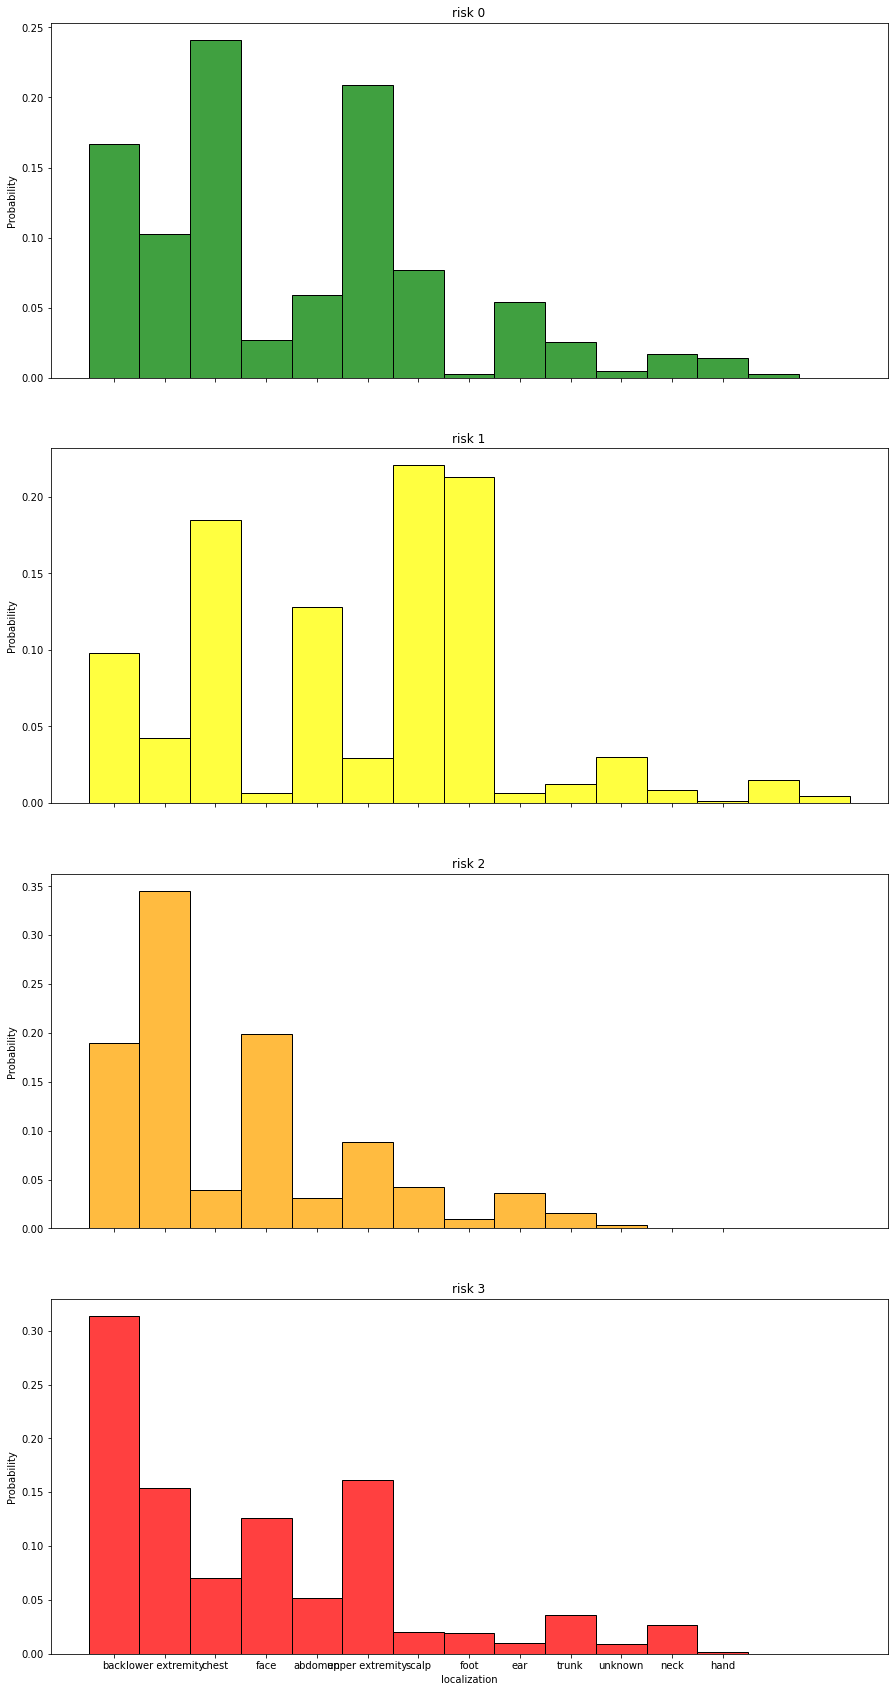

In [84]:
fig, axs = plt.subplots(4,1, figsize=(15,30), sharex=True)

sns.histplot(x='localization', data=df[df['risk'] == 0.0], color='green', stat='probability', ax=axs[0]).set_title('risk 0')
sns.histplot(x='localization', data=df[df['risk'] == 1.0], color='yellow', stat='probability', ax=axs[1]).set_title('risk 1')
sns.histplot(x='localization', data=df[df['risk'] == 2.0], color='orange', stat='probability', ax=axs[2]).set_title('risk 2')
sns.histplot(x='localization', data=df[df['risk'] == 3.0], color='red', stat='probability', ax=axs[3]).set_title('risk 3')

In [5]:
X = []

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (150,200))
    img = image.img_to_array(img) / 255.0
    
    
    X.append(img)

100%|██████████| 10015/10015 [01:01<00:00, 162.65it/s]


In [6]:
X = np.array(X)

X.shape

(10015, 150, 200, 3)

In [7]:
risk = []

for ele in df['risk']:
    risk.append(tf.one_hot(int(ele), 4))
    
y = np.array(risk)
y.shape

(10015, 4)

In [29]:
ori_model = models.Sequential()
ori_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(150,200,3)))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(32, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(16, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Flatten(name="feature_output"))

ori_model.add(layers.Dense(1024, activation='relu'))
ori_model.add(layers.Dense(256, activation='relu'))
ori_model.add(layers.Dense(64, activation='relu'))
ori_model.add(layers.Dense(4))

In [12]:
ori_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
ori_model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16)

Train on 9013 samples, validate on 1002 samples
Epoch 1/10
9013/9013 [==============================] - 1395s 155ms/sample - loss: 0.8991 - accuracy: 0.6574 - val_loss: 1.8887 - val_accuracy: 0.2166
Epoch 2/10
9013/9013 [==============================] - 1399s 155ms/sample - loss: 0.7943 - accuracy: 0.6831 - val_loss: 7.8821 - val_accuracy: 0.6487
Epoch 3/10
9013/9013 [==============================] - 1506s 167ms/sample - loss: 0.7726 - accuracy: 0.6788 - val_loss: 0.8484 - val_accuracy: 0.6527
Epoch 4/10
9013/9013 [==============================] - 1506s 167ms/sample - loss: 0.7592 - accuracy: 0.6847 - val_loss: 2.2043 - val_accuracy: 0.6487
Epoch 5/10
9013/9013 [==============================] - 1505s 167ms/sample - loss: 0.7377 - accuracy: 0.6937 - val_loss: 4.0482 - val_accuracy: 0.6487
Epoch 6/10
9013/9013 [==============================] - 1505s 167ms/sample - loss: 0.7242 - accuracy: 0.7004 - val_loss: 1.0555 - val_accuracy: 0.6487
Epoch 7/10
9013/9013 [========================

In [33]:
ori_model.save('./models/feature')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/feature/assets


In [35]:
loaded_model = tf.keras.models.load_model("./models/feature")


feature_extractor = tf.keras.Model(
    inputs=loaded_model.inputs,
    outputs=loaded_model.get_layer(name="feature_output").output,
)

In [25]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)

100%|██████████| 10015/10015 [00:06<00:00, 1610.32it/s]


In [26]:
feature_vector = np.array(feature_vector)

In [27]:
feature_vector.shape

(10015, 17)

In [ ]:
image_features = feature_extractor(X)

In [ ]:
X = []
for img_feat, feat in zip(image_features, feature_vector):
    X.append(np.concatenate((img_feat, feat)))

X = np.array(X)

In [183]:
model = models.Sequential()

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [184]:
model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16, sample_weight=sample_weights)

NameError: name 'X' is not defined

In [2]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [3]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1179,HAM_0003081,ISIC_0033860,df,consensus,45.0,male,abdomen,vidir_modern
1,3482,HAM_0004982,ISIC_0025192,nv,follow_up,35.0,male,upper extremity,vidir_molemax
2,8596,HAM_0006342,ISIC_0024425,nv,histo,40.0,female,face,rosendahl
3,2317,HAM_0000536,ISIC_0031844,mel,histo,45.0,female,lower extremity,rosendahl
4,4710,HAM_0000334,ISIC_0026860,nv,follow_up,35.0,female,abdomen,vidir_molemax


In [4]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append('no')
    elif df.iloc[i]['dx'] == 'nv':
        risk.append('lo')
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append('md')
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append('hi')
        
df['risk'] = risk

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,1179,HAM_0003081,ISIC_0033860,df,consensus,45.0,male,abdomen,vidir_modern,no
1,3482,HAM_0004982,ISIC_0025192,nv,follow_up,35.0,male,upper extremity,vidir_molemax,lo
2,8596,HAM_0006342,ISIC_0024425,nv,histo,40.0,female,face,rosendahl,lo
3,2317,HAM_0000536,ISIC_0031844,mel,histo,45.0,female,lower extremity,rosendahl,hi
4,4710,HAM_0000334,ISIC_0026860,nv,follow_up,35.0,female,abdomen,vidir_molemax,lo


In [5]:
df['image_id'] = df['image_id'].apply(lambda x: x + '.jpg')

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,1179,HAM_0003081,ISIC_0033860.jpg,df,consensus,45.0,male,abdomen,vidir_modern,no
1,3482,HAM_0004982,ISIC_0025192.jpg,nv,follow_up,35.0,male,upper extremity,vidir_molemax,lo
2,8596,HAM_0006342,ISIC_0024425.jpg,nv,histo,40.0,female,face,rosendahl,lo
3,2317,HAM_0000536,ISIC_0031844.jpg,mel,histo,45.0,female,lower extremity,rosendahl,hi
4,4710,HAM_0000334,ISIC_0026860.jpg,nv,follow_up,35.0,female,abdomen,vidir_molemax,lo


In [51]:
# VGG-16
VGG_load = VGG16(weights='imagenet')

model = models.Sequential()
model.add(VGG_load)
model.add(layers.Dense(4))

In [8]:
data_gen = ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    vertical_flip=True, validation_split=0.1, zoom_range=0.3)

In [9]:
df['risk'].value_counts()

lo    6705
hi    1627
no    1356
md     327
Name: risk, dtype: int64

In [16]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training').class_indices

Found 8012 validated image filenames belonging to 4 classes.


{'hi': 0, 'lo': 1, 'md': 2, 'no': 3}

In [17]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation').class_indices

Found 2003 validated image filenames belonging to 4 classes.


{'hi': 0, 'lo': 1, 'md': 2, 'no': 3}

In [41]:
class_weights = {'hi':1, 'lo':0.25, 'md':5, 'no':1}

In [43]:
sample_weights = []

for i in range(0, 10015):
    sample_weights.append(class_weights[df.iloc[i]['risk']])
    
df['weight'] = sample_weights

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk,weight
0,1179,HAM_0003081,ISIC_0033860.jpg,df,consensus,45.0,male,abdomen,vidir_modern,no,1.00
1,3482,HAM_0004982,ISIC_0025192.jpg,nv,follow_up,35.0,male,upper extremity,vidir_molemax,lo,0.25
2,8596,HAM_0006342,ISIC_0024425.jpg,nv,histo,40.0,female,face,rosendahl,lo,0.25
3,2317,HAM_0000536,ISIC_0031844.jpg,mel,histo,45.0,female,lower extremity,rosendahl,hi,1.00
4,4710,HAM_0000334,ISIC_0026860.jpg,nv,follow_up,35.0,female,abdomen,vidir_molemax,lo,0.25


In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

model.fit(
    x=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training'),
    validation_data=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation'),
    epochs=50)

Found 8012 validated image filenames belonging to 4 classes.
Found 2003 validated image filenames belonging to 4 classes.


KeyboardInterrupt: 

In [40]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)
feature_vector = np.array(feature_vector)

feature_vector.shape

100%|██████████| 10015/10015 [00:06<00:00, 1620.45it/s]


(10015, 17)

In [70]:
unique, counts = np.unique(feature_vector, return_counts=True, axis=1)

In [69]:
unique

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1., nan,  0., ...,  0.,  0.,  0.],
       [ 1., nan,  0., ...,  0.,  0.,  0.],
       [ 1., nan,  1., ...,  0.,  0.,  0.]])

In [39]:
feature_extractor = tf.keras.Model(
    inputs=VGG_load.inputs,
    outputs=VGG_load.layers[-4].output,
)

In [ ]:
preprocessed = []

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    feat_vec = feature_vector[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file, target_size= (224,224))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img_feat = feature_extractor(img)

    preprocessed.append(np.concatenate((img_feat, feat_vec)))
    
preprocessed = np.array(preprocessed)

In [46]:
ohr = []

for i in range(0, 10015):
    risk = df.iloc[i]['risk']
    
    if risk == 'no':
        ohr.append(tf.one_hot(0, 4))
    elif risk == 'lo':
        ohr.append(tf.one_hot(1, 4))
    elif risk == 'md':
        ohr.append(tf.one_hot(2, 4))
    elif risk == 'hi':
        ohr.append(tf.one_hot(3, 4))
        
ohr = np.array(ohr)

ohr.shape

(10015, 4)

In [71]:
ohr

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [47]:
new_model = models.Sequential()
new_model.add(layers.Dense(4096, activation='relu'))
new_model.add(layers.Dense(2048, activation='relu'))
new_model.add(layers.Dense(512, activation='relu'))
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dense(4))

In [49]:
new_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
new_model.fit(preprocessed, ohr, sample_weight=np.array(df['weight']), epochs=10, validation_split=0.1)

NameError: name 'preprocessed' is not defined